# Notebook description

This notebook explores the hypothesis of a contagious effect between friends considering reviewed businesses: Do people tend to use more those businesses used by their friends?

# Analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Params:

In [2]:
friends_path = '../data/friends.csv'
reviews_path = '../data/reviews.csv'

Read tables used below

In [3]:
friends = pd.read_csv(friends_path)
users = friends[['user_id']].drop_duplicates()
reviews = pd.read_csv(reviews_path)

For each combination of user_id and business_id such that at least one friend of the user has reviewed the business, count the actual number of friends that reviewed it:

In [4]:
friends_reviews = friends.merge(reviews.rename(columns={'user_id': 'friend_id'}), on='friend_id')
agg_reviews = friends_reviews.groupby(['user_id', 'business_id']).friend_id.nunique() \
    .reset_index() \
    .rename(columns={'friend_id': 'n_friends_with_reviews'})

Drop the raw count of friends and append a column with the fraction of friends instead.

In [5]:
n_friends = friends.groupby('user_id').count().reset_index()
n_friends.columns = ['user_id', 'n_friends']
agg_reviews = agg_reviews.merge(n_friends, how='left', on=['user_id']).fillna(0)
agg_reviews['fracc_friends_with_reviews'] = (agg_reviews.n_friends_with_reviews \
    / agg_reviews.n_friends).fillna(-1)
agg_reviews.drop('n_friends_with_reviews', axis=1, inplace=True)

Bin that column with the fraction of friends

In [6]:
agg_reviews['fracc_friends_with_reviews_bin'] = (agg_reviews.fracc_friends_with_reviews \
    / 0.03).astype(int) * 3

Append a column with a flag that indicates whether the user herself reviewed the business or not:

In [7]:
has_review = reviews.groupby(['user_id', 'business_id']).stars.count() \
    .reset_index() \
    .drop('stars', axis=1)
has_review['has_review'] = True
agg_reviews = agg_reviews \
     .merge(has_review, how='left', on=['user_id', 'business_id']) \
     .fillna({'has_review': False})

For each bin, compute the percentage of cases in which the user herself reviewed the business.

In [8]:
pctg_user_review = agg_reviews.groupby('fracc_friends_with_reviews_bin') \
    .has_review.agg(['mean', 'count']).reset_index()
pctg_user_review.columns = ['fracc_friends_with_reviews', 'pctg_review', 'n_cases']
pctg_user_review['pctg_review'] = 100 * pctg_user_review.pctg_review

The plot below shows the percentage of cases in which the user reviewed businesses that have been reviewed by a specific percentage of the user's friends, for different such percentages. 

<IPython.core.display.Javascript object>


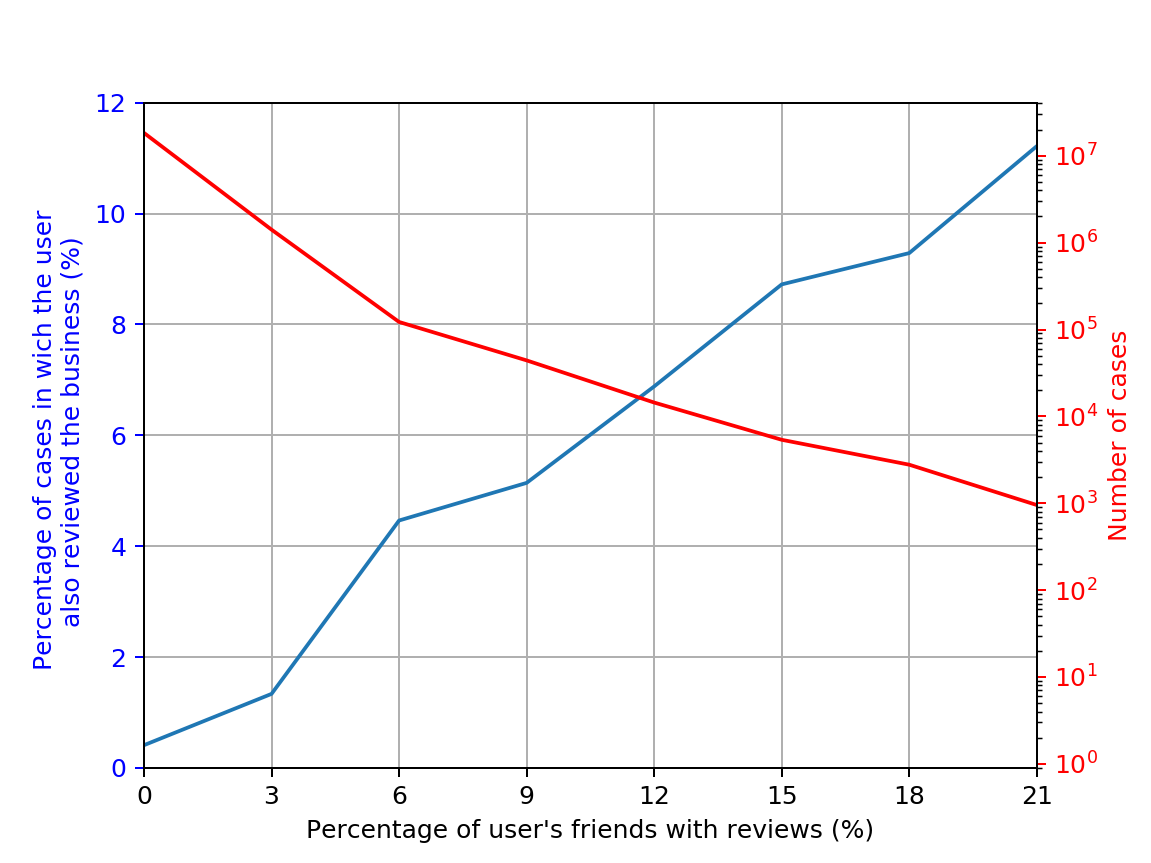

In [10]:
%matplotlib notebook

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(pctg_user_review.fracc_friends_with_reviews, pctg_user_review.pctg_review)
ax.grid()
ax.set_ylim([0, 12])
ax.set_xlim([0, 21])
ax.set_xticks([0, 3, 6, 9, 12, 15, 18, 21])
ax.set_xlabel('Percentage of user\'s friends with reviews (%)')
ax.set_ylabel('Percentage of cases in wich the user \n also reviewed the business (%)', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(pctg_user_review.fracc_friends_with_reviews, pctg_user_review.n_cases, 'r')
ax2.set_yscale('log')
ax2.set_ylabel('Number of cases', color='r')
ax2.tick_params('y', colors='r')

plt.show()

Note how the percentage of cases in which the user reviewed the business (blue line) increases as we consider sets of businesses reviewed by larger percentages of the user's friends, which supports the hypothesis of a contagious effect between friends. 

Note also that the cardinality of the considered sets of cases (red line) decreases to the right (less businneses are reviewed by larger percentages of users friends). The x-axis is adjusted to ignore the noisiest parts.